<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/EEG%20filtration%20DWT%20Fourier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Установим библиотеку pyedflib, которая позволяет читать EDF-файлы и ещё пару библиотек для вычислений и построения графиков

In [1]:
!pip install pyedflib
!pip install scipy
!pip install mne
!pip install PyWavelets
import os
import pyedflib
import numpy as np
import matplotlib.pyplot as plt
import pywt
import mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 79.3 MB/s eta 0:00:00


Подключаемся к Google Drive, чтобы получить доступ к файлу и укажем путь к файлу в Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/edf_process/EEG_example_FS_patient.edf'


Mounted at /content/drive


Загружаем файл и отображаем сигналы

Extracting EDF parameters from /content/drive/MyDrive/edf_process/EEG_example_FS_patient.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 20863  =      0.000 ...   162.992 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: EEG Fp1-G2, EEG Fp2-G2, EEG F3-G2, EEG F4-G2, EEG F7-G2, EEG ...
 chs: 24 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: 2023-01-27 00:39:07 UTC
 nchan: 24
 projs: []
 sfreq: 128.0 Hz
 subject_info: 1 item (dict)
>
Using matplotlib as 2D backend.


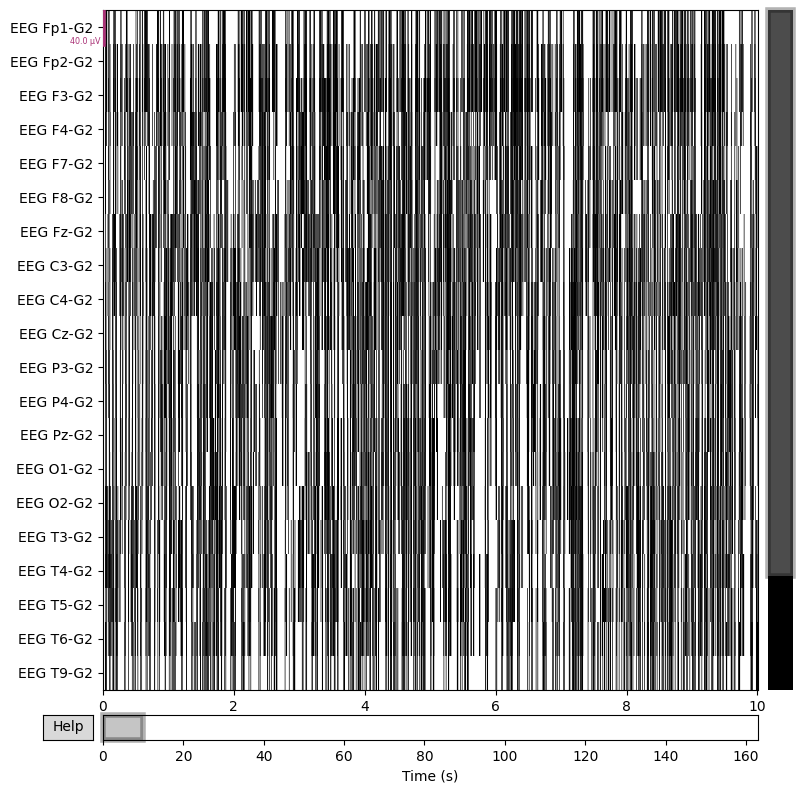

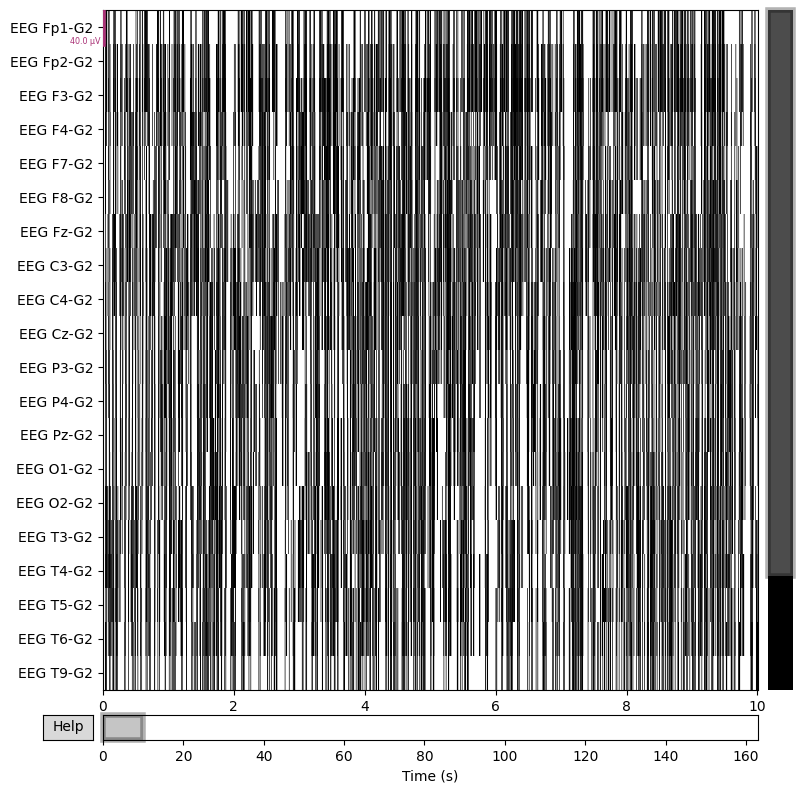

In [5]:
#file_path = 'https://raw.githubusercontent.com/TAUforPython/wavelets/main/dataset/EEG_example.edf'
# чтение данных из EDF-файла
raw = mne.io.read_raw_edf(file_path, preload=True)

# получим информацию о каналах
print(raw.info)

# отобразим сигналы
raw.plot()

Для упрощения дальнейшего взаимодействия выведем имена всех каналов

In [6]:
# получить данные как numpy массив
data, times = raw[:, :]
print(data.shape, times.shape) # (количество каналов, количество отсчётов), (количество отсчётов,)

channel_names = raw.ch_names
print(channel_names)

(24, 20864) (20864,)
['EEG Fp1-G2', 'EEG Fp2-G2', 'EEG F3-G2', 'EEG F4-G2', 'EEG F7-G2', 'EEG F8-G2', 'EEG Fz-G2', 'EEG C3-G2', 'EEG C4-G2', 'EEG Cz-G2', 'EEG P3-G2', 'EEG P4-G2', 'EEG Pz-G2', 'EEG O1-G2', 'EEG O2-G2', 'EEG T3-G2', 'EEG T4-G2', 'EEG T5-G2', 'EEG T6-G2', 'EEG T9-G2', 'EEG P9-G2', 'EEG F10-G2', 'EEG T10-G2', 'EEG P10-G2']


Извлечение и визуализация сигналов всех каналов

<ipython-input-7-703595d3a546>:19: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


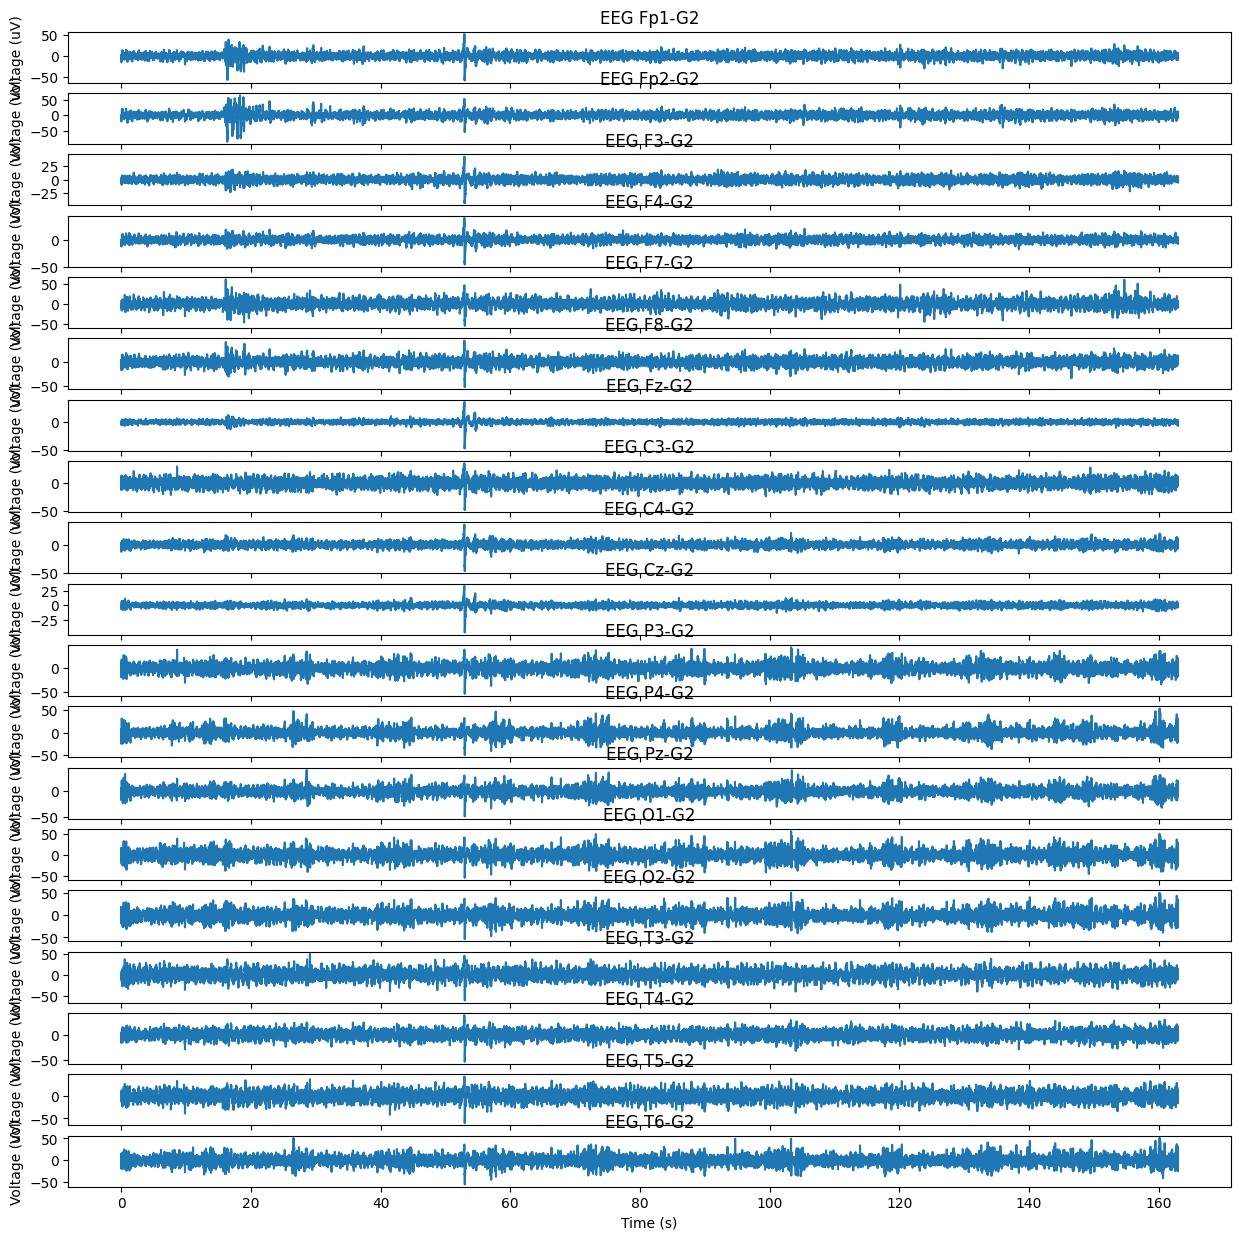

In [7]:
# Получение данных как numpy массив
data, times = raw[:, :]
# Получение имен каналов
channel_names = raw.ch_names

# Извлечение сигналов ЭЭГ из данных
eeg_data = data[0:19, :]

# Создание временной шкалы
time_axis = np.arange(0, len(times)) / raw.info['sfreq']

# Визуализация сигналов ЭЭГ всех каналов
fig, axes = plt.subplots(nrows=19, ncols=1, figsize=(15, 15))
for i in range(19):
    axes[i].plot(time_axis, eeg_data[i])
    axes[i].set_title(channel_names[i])
    axes[i].set_xlabel('Time (s)')
    axes[i].set_ylabel('Voltage (uV)')
plt.tight_layout()
plt.show()

выбираем нужные каналы и нормализуем их

In [9]:
#eeg_channels = ['EEG Fp1-G2', 'EEG Fp2-G2', 'EEG F3-G2', 'EEG F4-G2', 'EEG F7-G2', 'EEG F8-G2', 'EEG Fz-G2', 'EEG C3-G2', 'EEG C4-G2', 'EEG Cz-G2', 'EEG P3-G2', 'EEG P4-G2', 'EEG Pz-G2', 'EEG O1-G2', 'EEG O2-G2', 'EEG T3-G2', 'EEG T4-G2', 'EEG T5-G2', 'EEG T6-G2', 'EEG F9-G2', 'EEG T9-G2', 'EEG P9-G2', 'EEG F10-G2', 'EEG T10-G2', 'EEG P10-G2', 'EEG ECG-G2']
eeg_channels = channel_names
eeg_data = raw.copy().pick_channels(eeg_channels).get_data()
normalized_data = (eeg_data - np.mean(eeg_data, axis=1, keepdims=True)) / np.std(eeg_data, axis=1, keepdims=True)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


теперь мы задаём параметры фильтрации - выбор вейвлета и уровень декомпозиции. Применяем DWT для получения коэффициентов детализации и коэффициентов апроксимации. Потом используем обратное преобразование DWT для получения отфильтрованного сигналаа

In [10]:
import pywt

# определяем вейвлет-функцию
wavelet = 'db4'

# задаём уровень декомпозиции
level = 4

# разложение сигнала на коэффициенты вейвлет-преобразования
coeffs = pywt.wavedec(normalized_data, wavelet, level=level)

Здесь используется пороговая функция pywt.threshold(), которая преобразует коэффициенты детализации, обнуляя все значения меньше заданного значения порога value. Мы используем значение порога = 0, чтобы удалить шум высоких частот в. Затем обратное дискретное преобразование вейвлета выполняется с помощью функции pywt.waverec(), чтобы получить отфильтрованные данные.

In [11]:
# применяем вейвлет-фильтрацию
coeffs = pywt.wavedec(normalized_data, wavelet, level=4)
coeffs[1:] = [pywt.threshold(i, value=0, mode='soft') if i is not None else None for i in coeffs[1:]]
eeg_data_filt = pywt.waverec(coeffs, wavelet)

# фильтруем данные
eeg_data_filt = mne.filter.filter_data(eeg_data_filt, raw.info['sfreq'], l_freq=0.5, h_freq=30, verbose='ERROR')

info = mne.create_info(ch_names=raw.info['ch_names'], sfreq=raw.info['sfreq'], ch_types='eeg')
raw_filt = mne.io.RawArray(eeg_data_filt, info)

Creating RawArray with float64 data, n_channels=24, n_times=20864
    Range : 0 ... 20863 =      0.000 ...   162.992 secs
Ready.


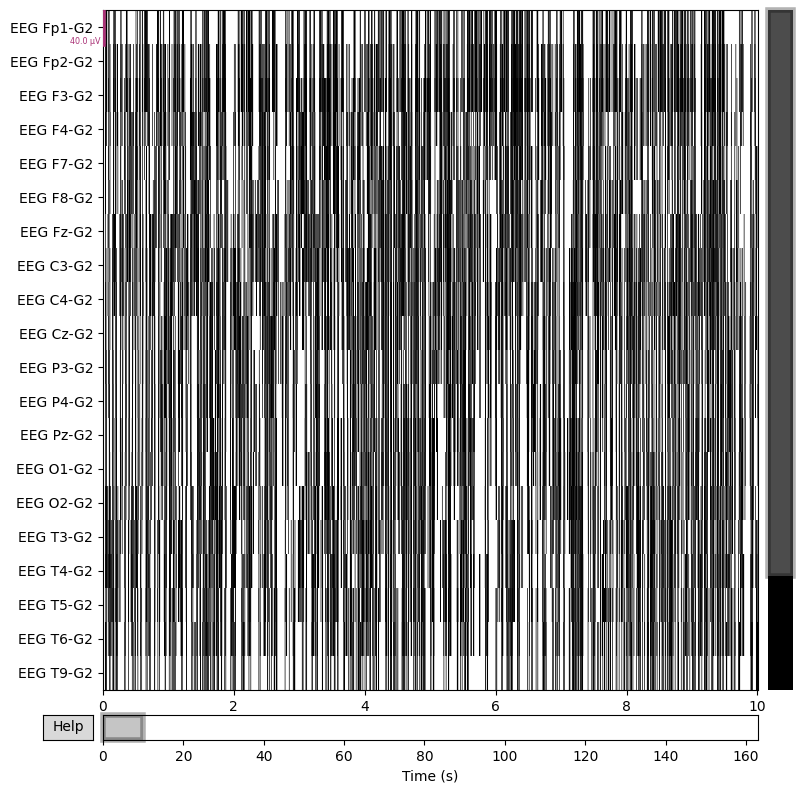

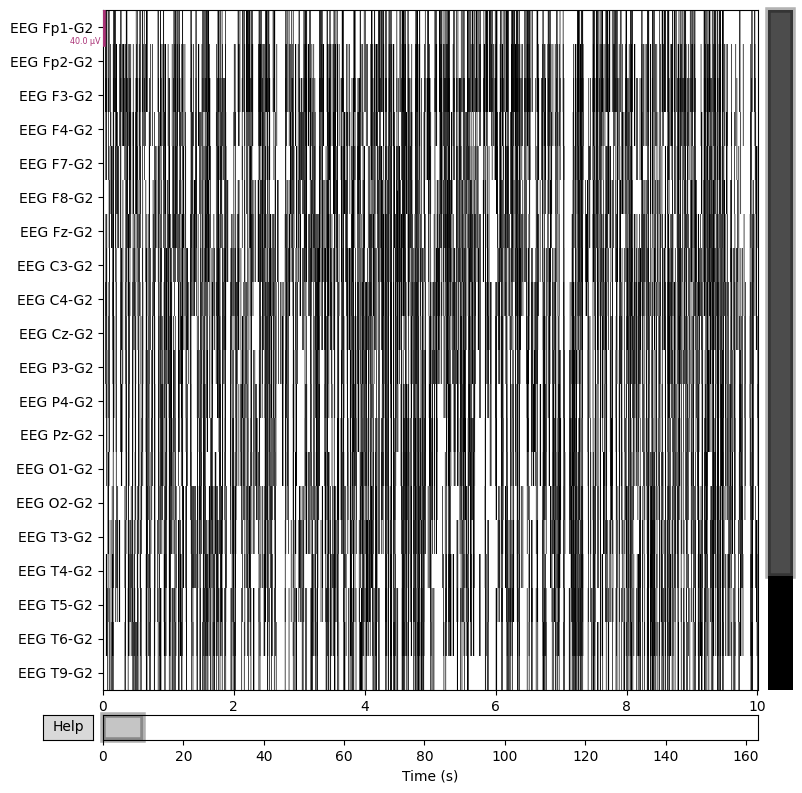

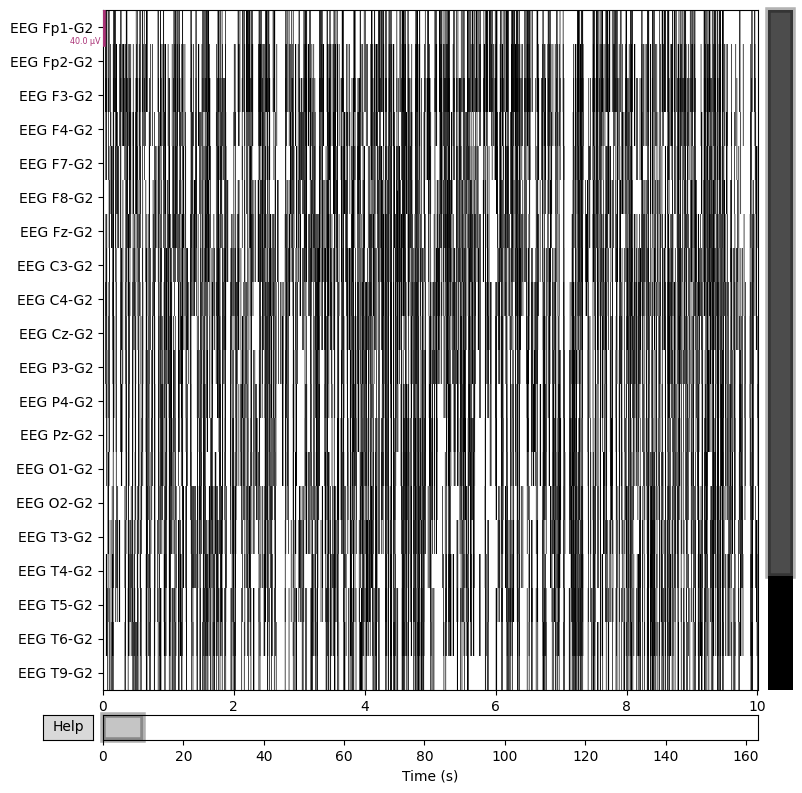

In [12]:
# визуализация исходных данных
raw.plot()

# визуализация отфильтрованных данных
raw_filt.plot()

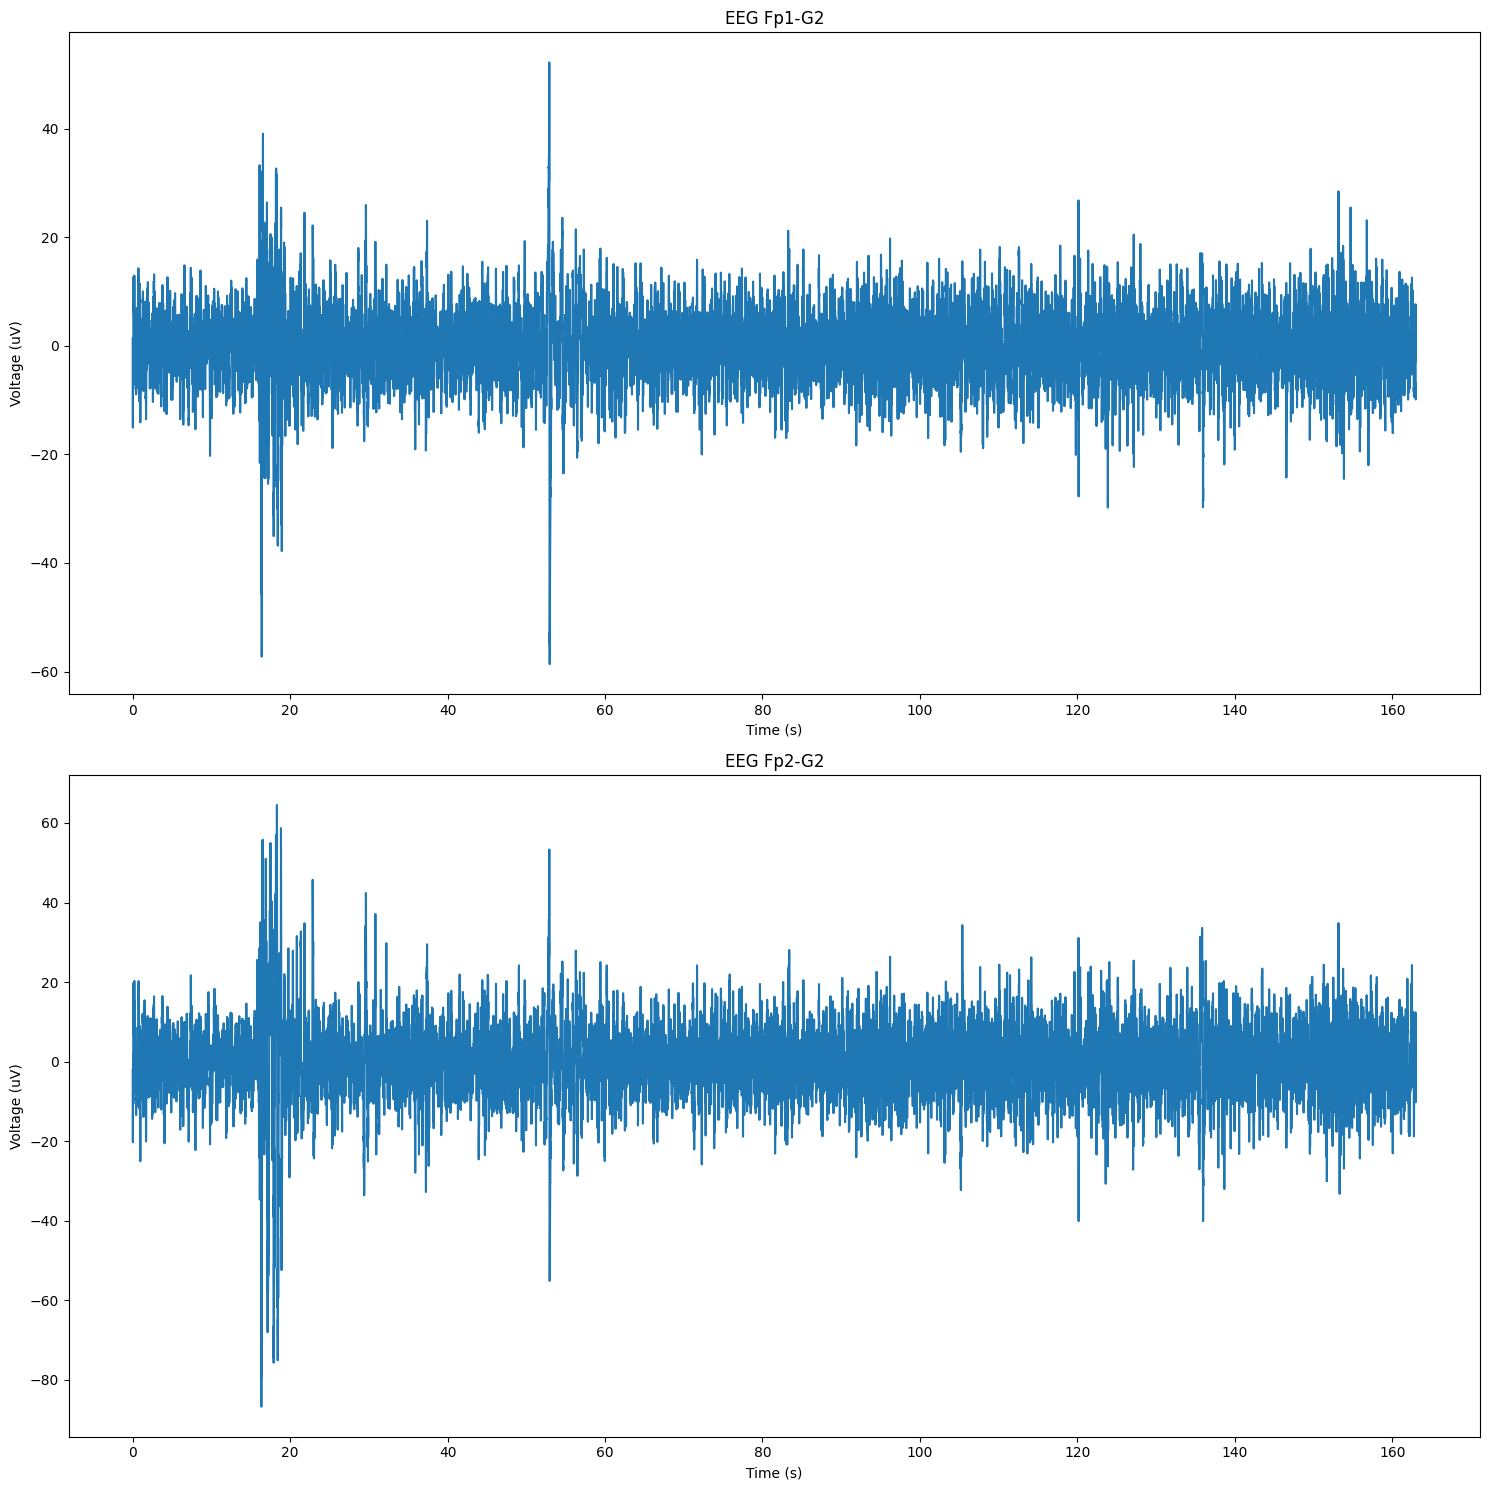

In [13]:
# Получение данных как numpy массив
data, times = raw[:, :]
# Получение имен каналов
channel_names = raw.ch_names

# Извлечение сигналов ЭЭГ из данных
eeg_data = data[0:19, :]

# Создание временной шкалы
time_axis = np.arange(0, len(times)) / raw.info['sfreq']

# Визуализация сигналов ЭЭГ всех каналов
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
for i in range(2):
    axes[i].plot(time_axis, eeg_data[i])
    axes[i].set_title(channel_names[i])
    axes[i].set_xlabel('Time (s)')
    axes[i].set_ylabel('Voltage (uV)')
plt.tight_layout()
plt.show()

В силу ограничений вычислительных ресурсов моего ноутбука, могу посторить данные только для двух каналов

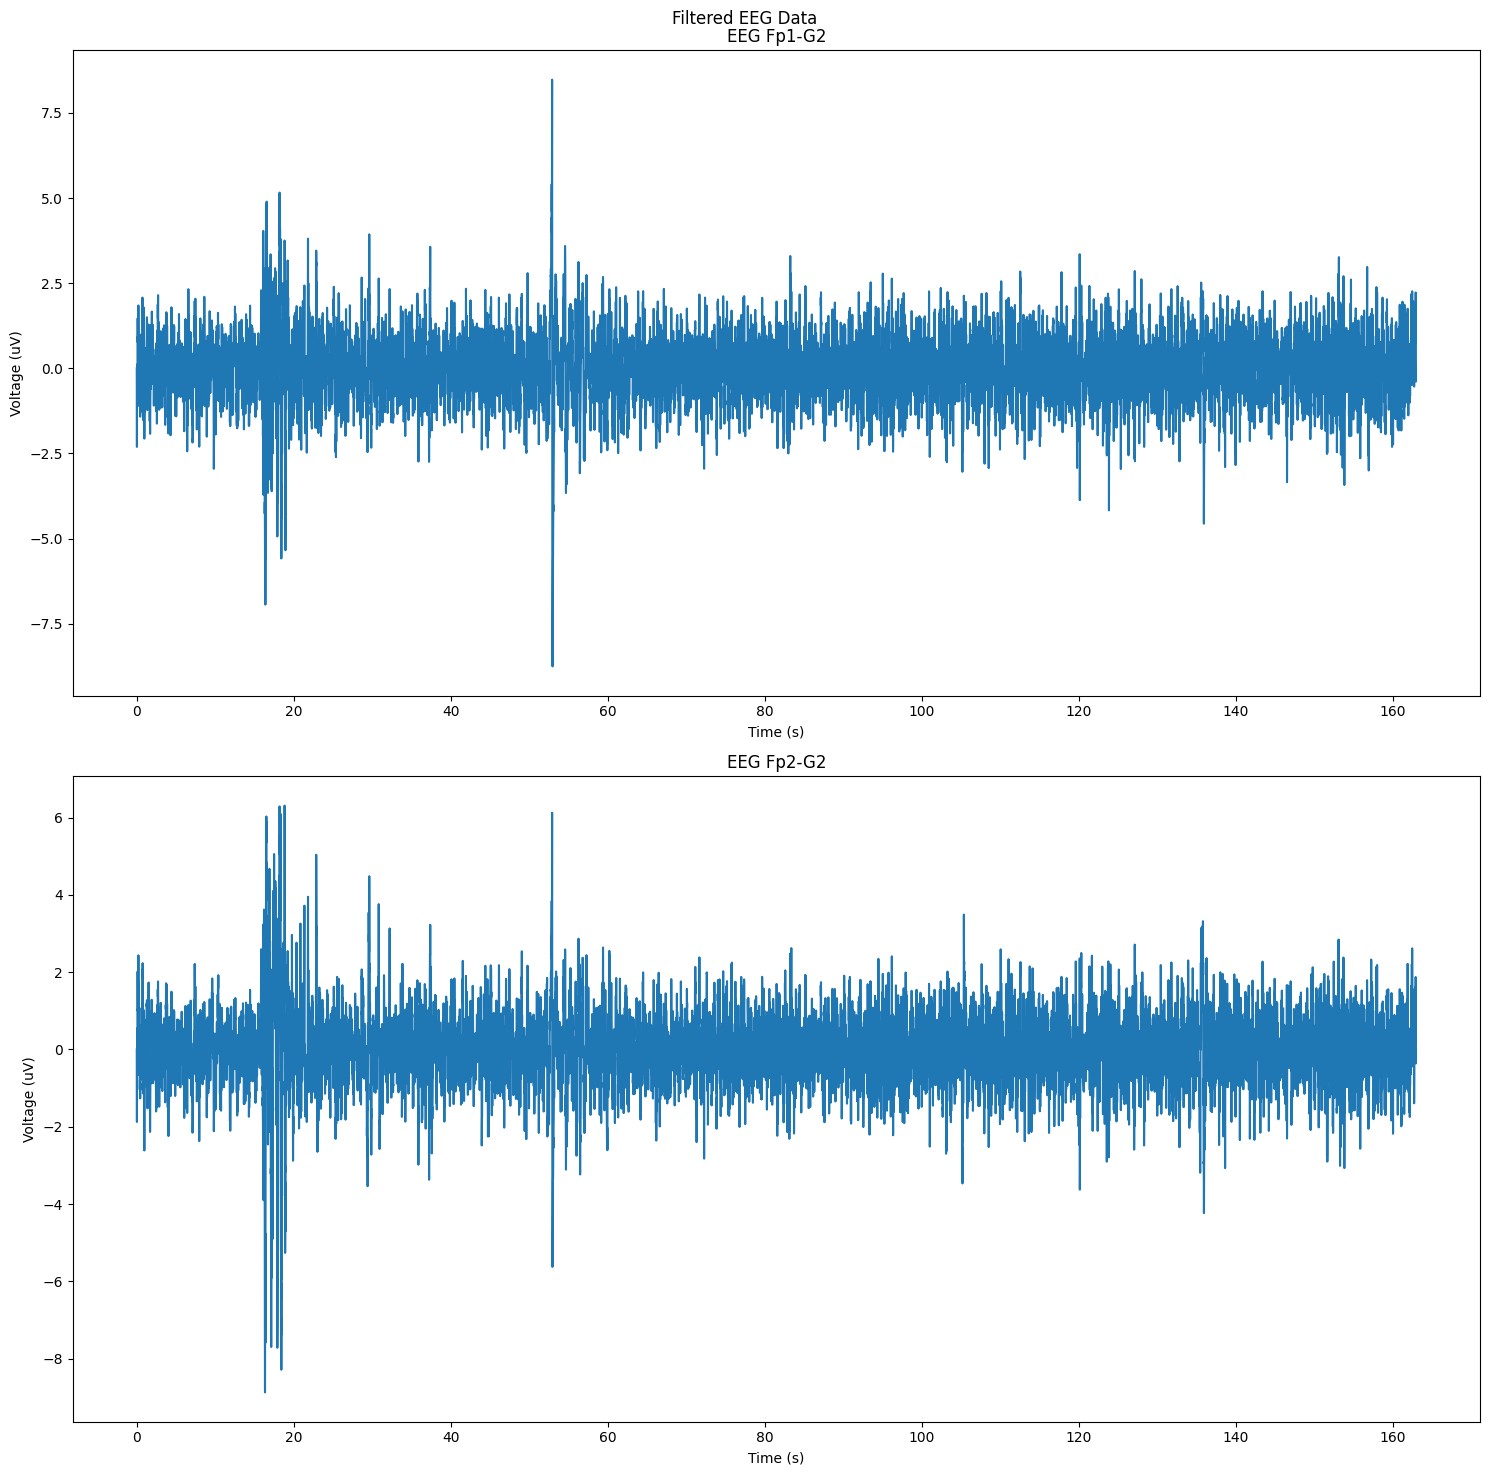

In [14]:
# построение отфильтрованных данных
fig_filt, axes_filt = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
for i in range(2):
    axes_filt[i].plot(time_axis, eeg_data_filt[i])
    axes_filt[i].set_title(channel_names[i])
    axes_filt[i].set_xlabel('Time (s)')
    axes_filt[i].set_ylabel('Voltage (uV)')
plt.suptitle('Filtered EEG Data')
plt.tight_layout()
plt.show()

Для фильтрации данных с помощью скользящего среднего с треугольным окном шириной 9, можно использовать функцию convolve из библиотеки numpy. Сначала необходимо задать ширину окна и коэффициенты треугольного фильтра. Затем применяем фильтр скользящего среднего с помощью функции convolve, указав режим "same" для того, чтобы выходной сигнал имел такую же длину, что и входной.

In [15]:
# задание ширины окна и коэффициентов фильтра
window_size = 9
triangle = np.array([i if i <= (window_size-1)/2 else window_size-i-1 for i in range(window_size)])
triangle = triangle / np.sum(triangle)
# фильтрация с помощью скользящего среднего
eeg_data_filt = np.apply_along_axis(lambda m: np.convolve(m, triangle, mode='same'), axis=1, arr=eeg_data)

Creating RawArray with float64 data, n_channels=19, n_times=20864
    Range : 0 ... 20863 =      0.000 ...    81.496 secs
Ready.


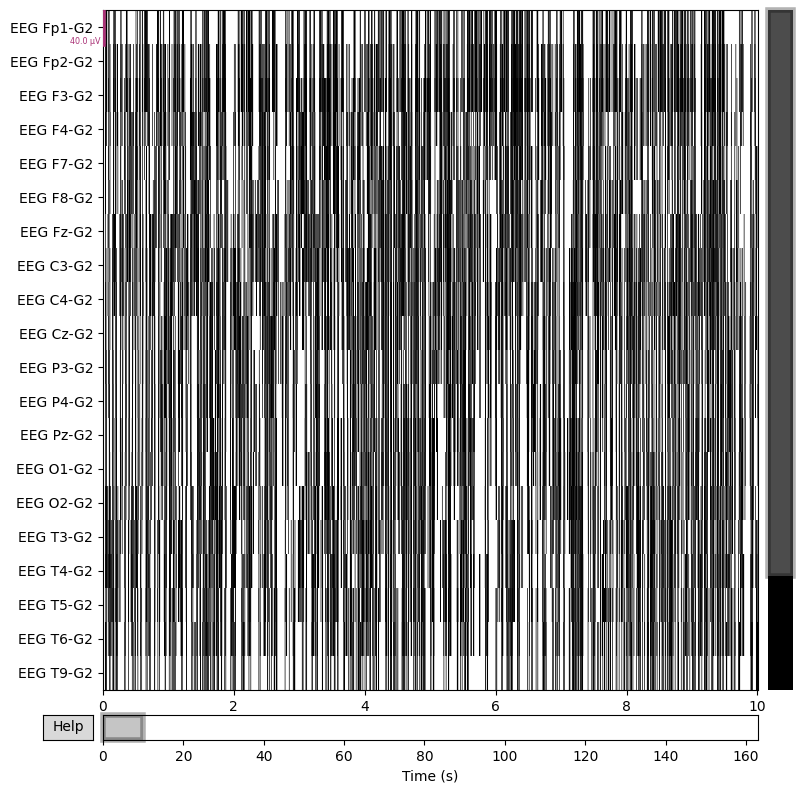

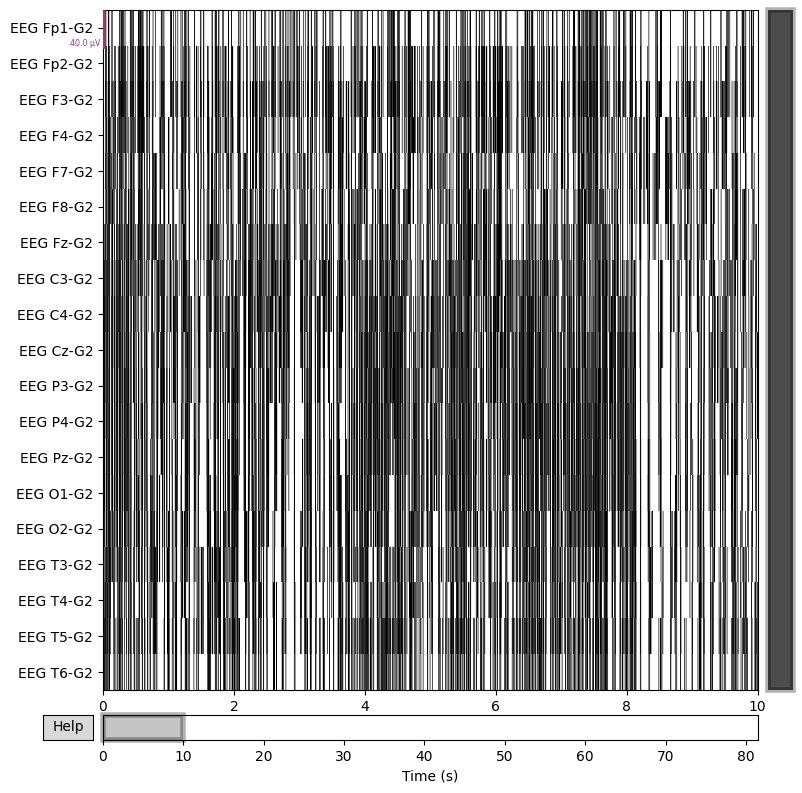

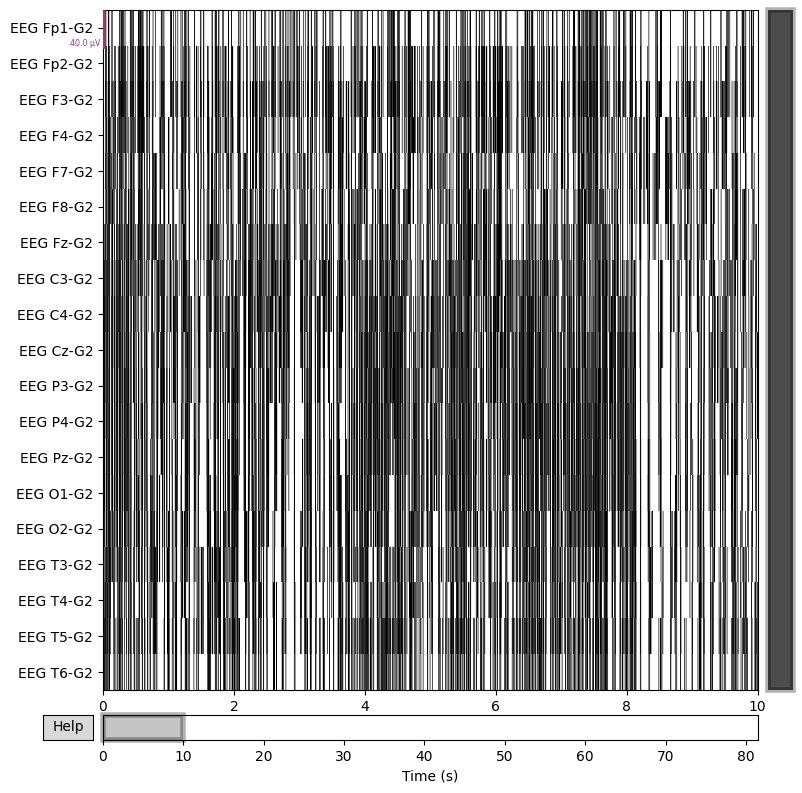

In [16]:
# создание объекта Info
sfreq = 256  # частота дискретизации
ch_names = ['EEG Fp1-G2', 'EEG Fp2-G2', 'EEG F3-G2', 'EEG F4-G2', 'EEG F7-G2', 'EEG F8-G2', 'EEG Fz-G2', 'EEG C3-G2', 'EEG C4-G2', 'EEG Cz-G2', 'EEG P3-G2', 'EEG P4-G2', 'EEG Pz-G2', 'EEG O1-G2', 'EEG O2-G2', 'EEG T3-G2', 'EEG T4-G2', 'EEG T5-G2', 'EEG T6-G2']
ch_types = ['eeg'] * 19
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

# создание объекта RawArray из отфильтрованных данных
raw_filt = mne.io.RawArray(eeg_data_filt, info)

# визуализация исходных данных
raw.plot()

# визуализация отфильтрованных данных данных
raw_filt.plot()

Фильтрация Баттерворта,здесь мы используем функцию butter_bandpass для определения коэффициентов фильтрации Баттерворта. Затем мы применяем фильтр к исходным данным с помощью функции filtfilt. Создаем объект mne.io.RawArray с отфильтрованными данными и визуализируем их

Creating RawArray with float64 data, n_channels=19, n_times=20864
    Range : 0 ... 20863 =      0.000 ...    81.496 secs
Ready.


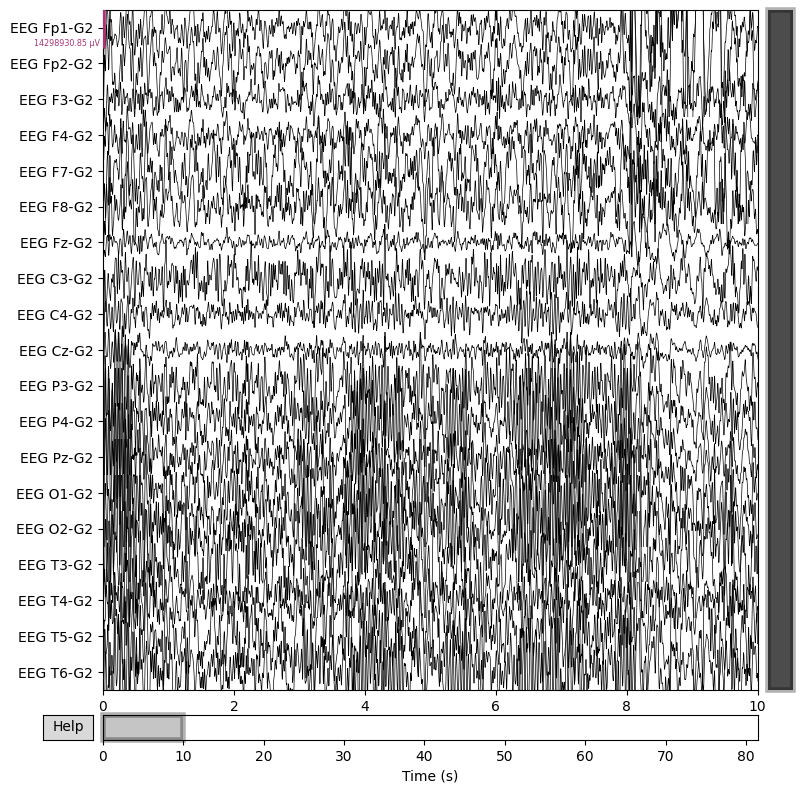

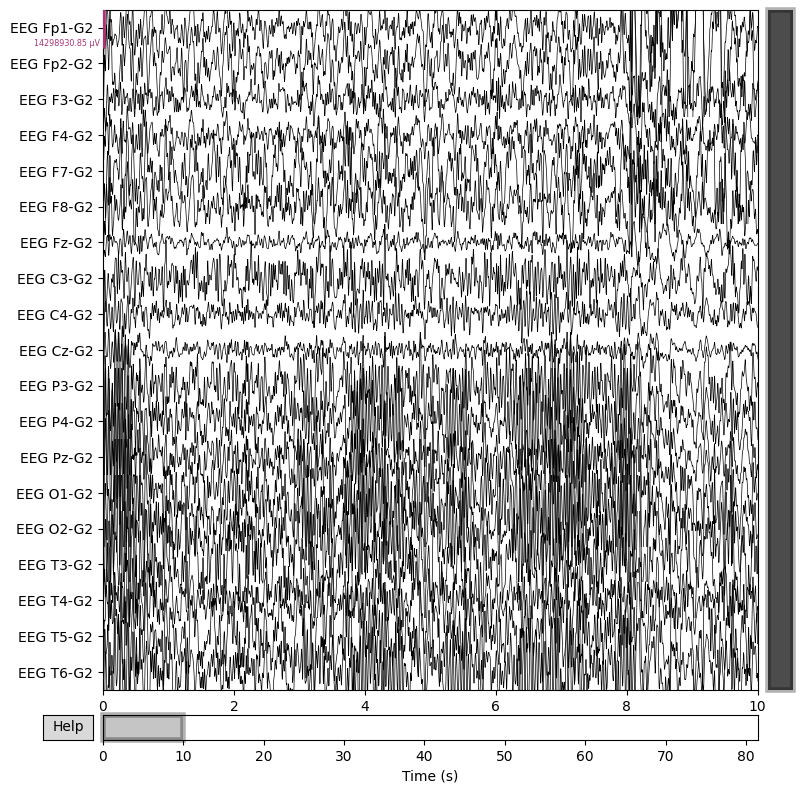

In [17]:
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

# Функция для фильтрации Баттерворта
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Задаем частоты срезов и порядок фильтра
lowcut = 2
highcut = 40
fs = 250
order = 4

# Применяем фильтр Баттерворта к исходным данным
b, a = butter_bandpass(lowcut, highcut, fs, order=order)
eeg_data_filt = filtfilt(b, a, eeg_data)

# Создаем объект mne.io.RawArray с отфильтрованными данными
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
raw_filt = mne.io.RawArray(eeg_data_filt, info)

# Визуализируем отфильтрованные данные
raw_filt.plot(start=0, duration=10, scalings='auto')

После фильтрации данных с помощью метода скользящего среднего с треугольным окном шириной 9 используем DWT фильтрацию

Creating RawArray with float64 data, n_channels=19, n_times=20864
    Range : 0 ... 20863 =      0.000 ...    81.496 secs
Ready.


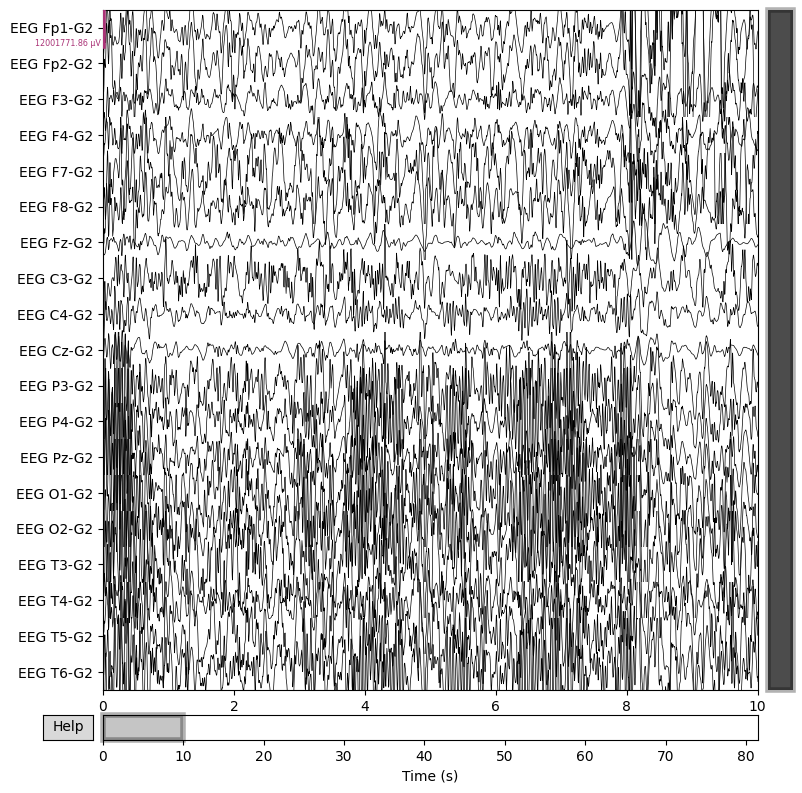

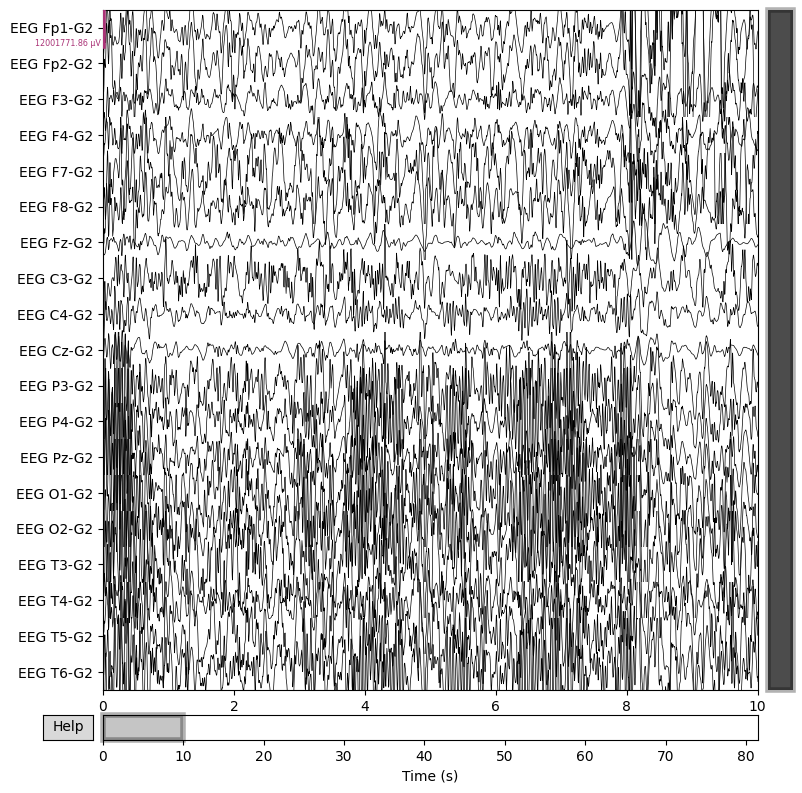

In [19]:
import pywt

# создание объекта pywt.wavedec с уровнем декомпозиции = 4 и типом фильтра = 'db4'
w = pywt.Wavelet('db4')
decomp_level = 4

# производим декомпозицию данных с помощью вейвлет-преобразования
coeffs = pywt.wavedec(eeg_data_filt, wavelet=w, level=decomp_level)

# фильтруем данные на каждом уровне декомпозиции
for i in range(1, decomp_level + 1):
    # устанавливаем порог для коэффициентов детализации
    threshold = pywt.threshold(coeffs[i], value=3, mode='soft', substitute=0.0)
    coeffs[i] = threshold

# сохраняем коэффициенты приближения
cA = coeffs[0]

# производим обратное вейвлет-преобразование для получения отфильтрованных данных
eeg_data_dwt = pywt.waverec(coeffs, wavelet=w)

# визуализация отфильтрованных данных
raw_dwt = mne.io.RawArray(eeg_data_dwt, info)
#raw_dwt.plot()
raw_dwt.plot(start=0, duration=10, scalings='auto')
